In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [5]:
# data analysis and wrangling
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


First, we should do some preprocessing. We concat boh dataframes to do all operations on both of them.

In [8]:
concatenate=[train_data,test_data]

* On train dataset  the Age, Cabin, Embarked columns have null values.
* On test dataset  the Age, Cabin columns have null values.
* On train dataset, 7 features are int or float and on test 6.
* On both datasets, 5 features are object.

In [9]:
print(train_data.columns)
print(train_data.info())
print(test_data.info())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (

#### From the code below we understand that:
* We have 891 unique names 
* Just 2 values for Sex:Male,Female. Males are on top with 577 freq. (64.7%).
* Just 3 values for Embarked and S is on top with 644 freq. (72%).
* Ticket  has 681 unique values.

In [10]:
# Only object columns
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Beckwith, Mr. Richard Leonard",male,347082,G6,S
freq,1,577,7,4,644


* I think there is correlation between [Age,Sex,Pclass] and survival.
* and no correlation between [PassengerId,Name,Ticket,Cabin] and survival. So, maybe should drop them.

#### Passengers on Pclass=1 have more lucky to survive.

In [11]:
train_data[['Pclass','Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


#### Women have more lucky to survive.

In [12]:
train_data[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [13]:
train_data[['SibSp','Survived']].groupby('SibSp').mean().sort_values(by='Survived',ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [14]:
train_data[['Parch','Survived']].groupby('Parch').mean().sort_values(by='Survived',ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


# Visualizing data

## Correlation between Age and Survived
* Passengers with 80 years old survived.
* Correlation between Age and SurvivedPassengers with 15-25 years old not survived.

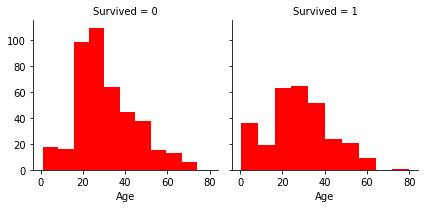

In [15]:
v=sns.FacetGrid(train_data,col='Survived')
v.map(plt.hist,'Age',bins=10,color='red')

## Correlation between Age, Pclass and Survived
* Most of the passengers on Pclass=1 survived.
* Most of the passengers on Pclass=3 not survived.
* Almost all children with age 5 or low on Pclass=2 survived.

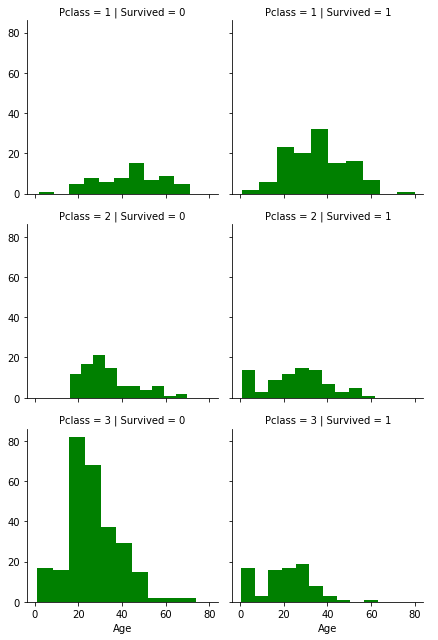

In [16]:
v=sns.FacetGrid(train_data,col='Survived',row='Pclass')
v.map(plt.hist,'Age',bins=10,color='green')
v.add_legend()

## Correlation between Age, Sex and Survived
* Almost all women on Pclass=1 and Pclass=2 survived.


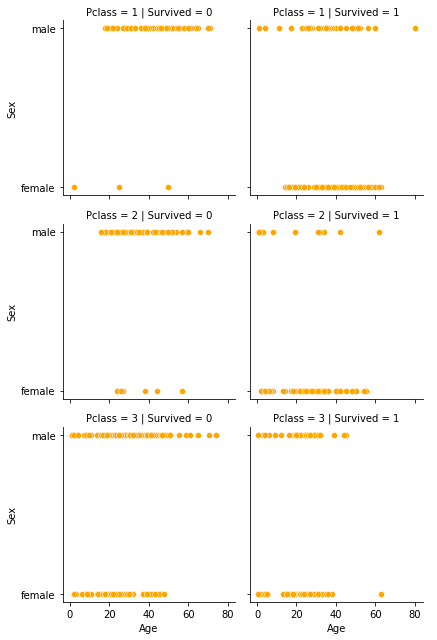

In [17]:
v=sns.FacetGrid(train_data,col='Survived',row='Pclass')
v.map(sns.scatterplot,'Age','Sex',color='orange')
v.add_legend()

## Correlation between Embarked, Sex, Pclass and Survived
* In Embarked=C males survived better.
* In Embarked=S and Embarked=Q females survived better.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


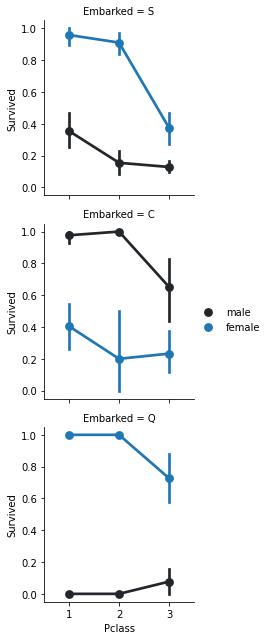

In [18]:
v=sns.FacetGrid(train_data,row='Embarked')
v.map(sns.pointplot,'Pclass','Survived','Sex')
v.add_legend()

## Correlation between Survived and Fare.
* Passengers who paid higher fare more survived.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


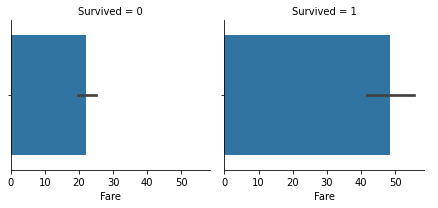

In [19]:
v=sns.FacetGrid(train_data,col='Survived')
v.map(sns.barplot,'Fare')
v.add_legend()

# Data Cleaning
 Drop Ticket, Cabin and PassengerId

In [20]:
train_data=train_data.drop(['PassengerId','Ticket','Cabin'],axis=1)
test_data=test_data.drop(['Ticket','Cabin'],axis=1)


In [21]:
concatenate=[train_data,test_data]

First, we want to extract title of names and after that drop name because we don't need names.

In [22]:
for dataset in concatenate:
    dataset['Title']=dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_data['Title'],train_data['Sex'])
# train_data['Title'].unique().tolist()

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Replace the titles.

In [23]:
for dataset in concatenate:
    dataset['Title']=dataset['Title'].replace('Ms','Miss')
    dataset['Title']=dataset['Title'].replace('Mme','Miss')
    dataset['Title']=dataset['Title'].replace('Mlle','Miss')
    dataset['Title']=dataset['Title'].replace('Sir','Mr')
    dataset['Title']=dataset['Title'].replace(['Col','Don','Rev','Dr','Major','Lady','Capt','Countess','Jonkheer'],'uncommon')
    
train_data[['Title','Survived']].groupby('Title').mean().sort_values(by='Survived',ascending=False)    

,Survived
Title,
Mrs,0.792000
Miss,0.704301
Master,0.575000
uncommon,0.318182
Mr,0.158301


Convert Title to categorical.

In [24]:
category={'Mr':1,'Mrs':2,'Miss':3,'Master':4,'uncommon':5}
for dataset in concatenate:
    dataset['Title']=dataset['Title'].map(category)
    
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,3
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now we can drop name from both datasets.

In [25]:
train_data=train_data.drop('Name',axis=1)
test_data=test_data.drop('Name',axis=1)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,3
3,1,1,female,35.0,1,0,53.1000,S,2
4,0,3,male,35.0,0,0,8.0500,S,1


We have null values on Age column.

In [26]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   Title     891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [27]:
concatenate=[train_data,test_data]


Convert Sex to categorical.

In [28]:
for dataset in concatenate:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,2
2,1,3,1,26.0,0,0,7.9250,S,3
3,1,1,1,35.0,1,0,53.1000,S,2
4,0,3,0,35.0,0,0,8.0500,S,1


In [29]:
guess=np.zeros(5)
guess

array([0., 0., 0., 0., 0.])

Find Ages for null values by Title.

In [30]:
for dataset in concatenate:
    for i in range(1,6):
        gg=dataset[(dataset['Title'] == i)]['Age'].dropna()
        ages = gg.median()
#             print(gg)
        guess[i-1] =  ages
    
        
print(guess)             
          

[28.5 36.5 22.   7.  47. ]


In [31]:
for dataset in concatenate:   
    for i in range(1,6):
            dataset.loc[(dataset['Age'].isnull()) & (dataset['Title']==i),'Age']=guess[i-1]
            print(guess[i-1])
    dataset['Age']=dataset['Age'].astype(int)

28.5
36.5
22.0
7.0
47.0
28.5
36.5
22.0
7.0
47.0


Group ages.

In [32]:
train_data['Age_Group']=pd.cut(train_data['Age'],5)
train_data[['Age_Group','Survived']].groupby('Age_Group').mean()

,Survived
Age_Group,
"(-0.08, 16.0]",0.548077
"(16.0, 32.0]",0.328032
"(32.0, 48.0]",0.436275
"(48.0, 64.0]",0.434783
"(64.0, 80.0]",0.090909


In [33]:
for dataset in concatenate:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 64, 'Age']= 5
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Group
0,0,3,0,2,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,3,1,0,71.2833,C,2,"(32.0, 48.0]"
2,1,3,1,2,0,0,7.9250,S,3,"(16.0, 32.0]"
3,1,1,1,3,1,0,53.1000,S,2,"(32.0, 48.0]"
4,0,3,0,3,0,0,8.0500,S,1,"(32.0, 48.0]"


Drop Age_Group

In [34]:
train_data=train_data.drop('Age_Group',axis=1)
concatenate=[train_data,test_data]
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2,1,0,7.2500,S,1
1,1,1,1,3,1,0,71.2833,C,2
2,1,3,1,2,0,0,7.9250,S,3
3,1,1,1,3,1,0,53.1000,S,2
4,0,3,0,3,0,0,8.0500,S,1


Combine Parch and SibSp columns

In [35]:
for dataset in concatenate:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

train_data[['Family', 'Survived']].groupby(['Family']).mean().sort_values(by='Survived', ascending=False)
# train_data[train_data['Family']==1]

,Survived
Family,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


Find how many of passengers are alone.

In [36]:
for dataset in concatenate:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['Family'] == 1, 'IsAlone'] = 1

train_data[['IsAlone', 'Survived']].groupby(['IsAlone']).mean()

,Survived
IsAlone,
0,0.505650
1,0.303538


Drop Family,ParCh and SibSp

In [37]:
train_data = train_data.drop(['Parch', 'SibSp', 'Family'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp', 'Family'], axis=1)
concatenate = [train_data, test_data]

train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,2,7.2500,S,1,0
1,1,1,1,3,71.2833,C,2,0
2,1,3,1,2,7.9250,S,3,1
3,1,1,1,3,53.1000,S,2,0
4,0,3,0,3,8.0500,S,1,1


Fill null values for Embarked with 'S' because most freq. value is S.

In [38]:
for dataset in concatenate:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
train_data[['Embarked', 'Survived']].groupby(['Embarked']).mean().sort_values(by='Survived', ascending=False)


,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


Convert Embarked to categorical value.

In [39]:
for dataset in concatenate:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'Q': 1, 'C': 2} ).astype(int)

train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,2,7.2500,0,1,0
1,1,1,1,3,71.2833,2,2,0
2,1,3,1,2,7.9250,0,3,1
3,1,1,1,3,53.1000,0,2,0
4,0,3,0,3,8.0500,0,1,1


In [40]:
test_data['Fare'].fillna(test_data['Fare'].dropna().median(), inplace=True)
test_data.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,3,7.8292,1,1.0,1
1,893,3,1,3,7.0000,0,2.0,0
2,894,2,0,4,9.6875,1,1.0,1
3,895,3,0,2,8.6625,0,1.0,1
4,896,3,1,2,12.2875,0,2.0,0


Seperate Fare 

In [41]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareBand', 'Survived']].groupby(['FareBand']).mean().sort_values(by='FareBand', ascending=True)

,Survived
FareBand,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


Category of Fare

In [42]:
for dataset in concatenate:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_data = train_data.drop(['FareBand'], axis=1)
concatenate = [train_data, test_data]
    
print(train_data.head())
print(test_data.head())

   Survived  Pclass  Sex  Age  Fare  Embarked  Title  IsAlone
0         0       3    0    2     0         0      1        0
1         1       1    1    3     3         2      2        0
2         1       3    1    2     1         0      3        1
3         1       1    1    3     3         0      2        0
4         0       3    0    3     1         0      1        1
   PassengerId  Pclass  Sex  Age  Fare  Embarked  Title  IsAlone
0          892       3    0    3     0         1    1.0        1
1          893       3    1    3     0         0    2.0        0
2          894       2    0    4     1         1    1.0        1
3          895       3    0    2     1         0    1.0        1
4          896       3    1    2     1         0    2.0        0


Now we can predict and use Machine Learning Techniques.
* We use these Machine Learning Techniques:
1. Random Forest
2. Decision Tree
3. KNN
4. Support Vector Machines
5. Logistic Regression
6. Linear SVC
7. Stochastic Gradient Decent
8. Perceptron
9. Naive Bayes

In [52]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop('PassengerId',axis=1).copy()


,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,3,0,3,0,1,1.0,1
1,3,1,3,0,0,2.0,0
2,2,0,4,1,1,1.0,1
3,3,0,2,1,0,1.0,1
4,3,1,2,1,0,2.0,0


# Logistic Regression

In [53]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)
acc_LR = round(LR.score(X_train, Y_train) * 100, 2)
acc_LR

78.79

# SVM

In [54]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.49

# KNN

In [55]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.51

# Naive Bayse

In [56]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.77

# Perceptron

In [57]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

73.51

# LinearSVC

In [58]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


78.79

# Stochastic Gradient Descent

In [59]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

72.62

# Decision Tree

In [60]:

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

87.09

# Random Forest

In [61]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

87.09

# Best Models are Random Forest and Decision Tree

In [63]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_LR, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,87.09
8,Decision Tree,87.09
1,KNN,84.51
0,Support Vector Machines,82.49
2,Logistic Regression,78.79
7,Linear SVC,78.79
4,Naive Bayes,76.77
5,Perceptron,73.51
6,Stochastic Gradient Decent,72.62


In [66]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": Y_pred
    })

submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
